===== CHUỖI THỜI GIAN GDP =====


,GDP
Year,
2000-01-01,3.117252e+10
2001-01-01,3.268520e+10
2002-01-01,3.506411e+10
2003-01-01,3.955251e+10
2004-01-01,4.542785e+10



===== KIỂM TRA TÍNH DỪNG (ADF TEST) =====
ADF Statistic : 1.0041
p-value       : 0.9943
→ Chuỗi GDP KHÔNG dừng → cần sai phân bậc 1

Train: 2000 → 2018
Test : 2019 → 2023

===== TÓM TẮT MÔ HÌNH ARIMA =====
                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   19
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -441.284
Date:                Wed, 14 Jan 2026   AIC                            888.568
Time:                        21:52:53   BIC                            891.239
Sample:                    01-01-2000   HQIC                           888.936
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.

C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


,GDP_Thực_tế,GDP_Dự_đoán
Year,,
2019-01-01,3.343650e+11,3.285450e+11
2020-01-01,3.466160e+11,3.464773e+11
2021-01-01,3.664750e+11,3.639168e+11
2022-01-01,4.134450e+11,3.808771e+11
2023-01-01,4.338580e+11,3.973712e+11


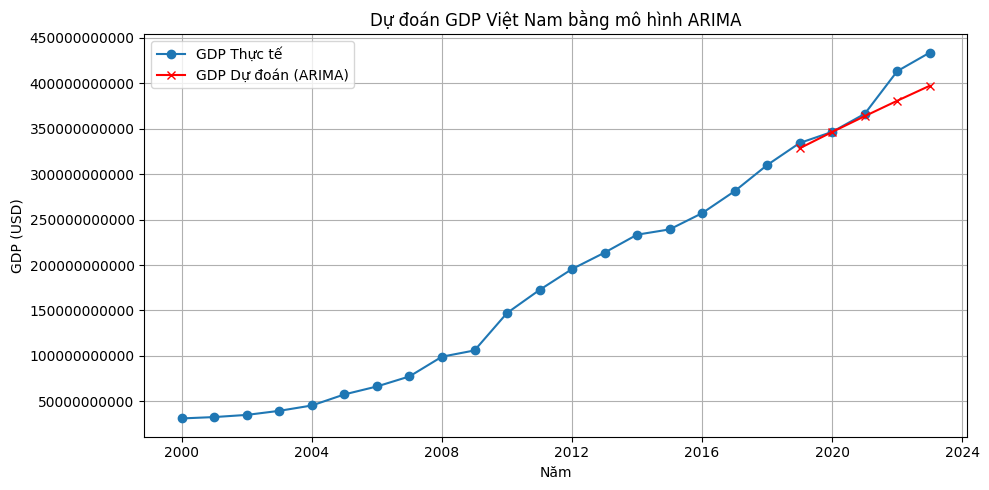

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. ĐỌC DỮ LIỆU
df = pd.read_csv("macro_vietnam_processed.csv")

# Chỉ lấy chuỗi GDP theo năm
ts = df[["Year", "GDP"]].copy()
ts["Year"] = pd.to_datetime(ts["Year"], format="%Y")
ts.set_index("Year", inplace=True)

print("===== CHUỖI THỜI GIAN GDP =====")
display(ts.head())

# 2. KIỂM TRA TÍNH DỪNG (ADF TEST)
adf_result = adfuller(ts["GDP"])

print("\n===== KIỂM TRA TÍNH DỪNG (ADF TEST) =====")
print(f"ADF Statistic : {adf_result[0]:.4f}")
print(f"p-value       : {adf_result[1]:.4f}")

if adf_result[1] < 0.05:
    print("→ Chuỗi GDP là DỪNG (stationary)")
    d = 0
else:
    print("→ Chuỗi GDP KHÔNG dừng → cần sai phân bậc 1")
    d = 1

# 3. CHIA TRAIN / TEST (GIẤU 5 NĂM CUỐI)
n_test = 5
train = ts.iloc[:-n_test]
test  = ts.iloc[-n_test:]

print(f"\nTrain: {train.index.year.min()} → {train.index.year.max()}")
print(f"Test : {test.index.year.min()} → {test.index.year.max()}")

# 4. HUẤN LUYỆN MÔ HÌNH ARIMA
# (p,d,q) chọn đơn giản để minh họa khoa học
model = ARIMA(train["GDP"], order=(1, d, 1))
model_fit = model.fit()

print("\n===== TÓM TẮT MÔ HÌNH ARIMA =====")
print(model_fit.summary())

# 5. DỰ ĐOÁN TRÊN TẬP TEST
forecast = model_fit.forecast(steps=n_test)
forecast.index = test.index

# 6. ĐÁNH GIÁ MÔ HÌNH
mae = mean_absolute_error(test["GDP"], forecast)
rmse = np.sqrt(mean_squared_error(test["GDP"], forecast))
r2 = r2_score(test["GDP"], forecast)

print("\n===== ĐÁNH GIÁ MÔ HÌNH ARIMA =====")
print(f"MAE : {mae:,.0f} USD")
print(f"RMSE: {rmse:,.0f} USD")
print(f"R²  : {r2:.4f}")

# 7. BẢNG SO SÁNH THỰC TẾ & DỰ ĐOÁN
result_df = pd.DataFrame({
    "GDP_Thực_tế": test["GDP"],
    "GDP_Dự_đoán": forecast
})

print("\n===== SO SÁNH GDP THỰC TẾ & DỰ ĐOÁN =====")
display(result_df)

# 8. BIỂU ĐỒ SO SÁNH
plt.figure(figsize=(10,5))

plt.plot(ts.index, ts["GDP"], label="GDP Thực tế", marker="o")
plt.plot(test.index, forecast, label="GDP Dự đoán (ARIMA)", marker="x", color="red")

plt.title("Dự đoán GDP Việt Nam bằng mô hình ARIMA")
plt.xlabel("Năm")
plt.ylabel("GDP (USD)")
plt.legend()
plt.grid(True)
plt.ticklabel_format(style="plain", axis="y")

plt.tight_layout()
plt.show()
